<a href="https://colab.research.google.com/github/Fahdyhasanugrah/ExceptionHandling10/blob/main/fahdycitrapraktikum7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
import io, math, zlib, heapq
from collections import Counter



Saving kartuntest.jpg to kartuntest (1).jpg
Filename: kartuntest (1).jpg
Image shape: (736, 736, 3) dtype: uint8


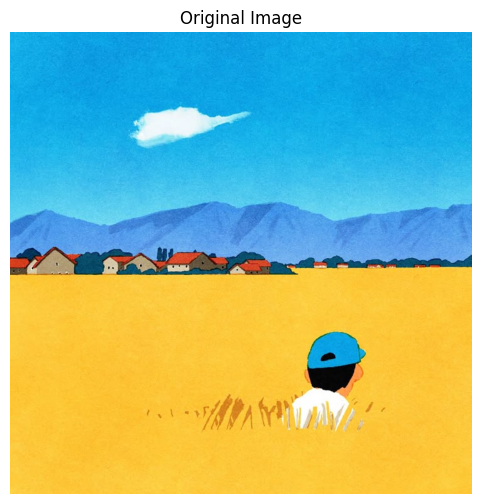

In [9]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

img = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")
img_np = np.array(img)  # shape: (H, W, 3), dtype uint8

print("Filename:", filename)
print("Image shape:", img_np.shape, "dtype:", img_np.dtype)

plt.figure(figsize=(6,6))
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")
plt.show()


In [10]:
def img_to_bytes(img_np: np.ndarray) -> bytes:
    # simpan dimensi + data pixel
    h, w, c = img_np.shape
    header = np.array([h, w, c], dtype=np.int32).tobytes()
    return header + img_np.tobytes()

def bytes_to_img(data: bytes) -> np.ndarray:
    header = np.frombuffer(data[:12], dtype=np.int32)
    h, w, c = map(int, header)
    arr = np.frombuffer(data[12:], dtype=np.uint8).reshape((h, w, c))
    return arr

def show_before_after(before_np, after_np, title=""):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(before_np); plt.title("Before"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(after_np); plt.title("After"); plt.axis("off")
    plt.suptitle(title)
    plt.show()

def mse(a, b):
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    return float(np.mean((a-b)**2))

def psnr(a, b):
    m = mse(a, b)
    if m == 0:
        return float("inf")
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(m))

def compression_report(original_bytes_len, compressed_bytes_len):
    ratio = original_bytes_len / compressed_bytes_len if compressed_bytes_len > 0 else float("inf")
    saving = (1 - compressed_bytes_len/original_bytes_len) * 100
    return ratio, saving

In [11]:
def rle_compress(data: bytes) -> bytes:
    # output: [value(1 byte), run_length(2 bytes little endian)] berulang
    if not data:
        return b""
    out = bytearray()
    prev = data[0]
    run = 1
    for b in data[1:]:
        if b == prev and run < 65535:
            run += 1
        else:
            out.append(prev)
            out += int(run).to_bytes(2, "little")
            prev = b
            run = 1
    out.append(prev)
    out += int(run).to_bytes(2, "little")
    return bytes(out)

def rle_decompress(comp: bytes) -> bytes:
    out = bytearray()
    i = 0
    n = len(comp)
    while i < n:
        value = comp[i]
        run = int.from_bytes(comp[i+1:i+3], "little")
        out += bytes([value]) * run
        i += 3
    return bytes(out)


RLE
Original bytes: 1625100
Compressed bytes: 4859322
Compression ratio: 0.334 x
Space saving: -199.02 %
PSNR: inf


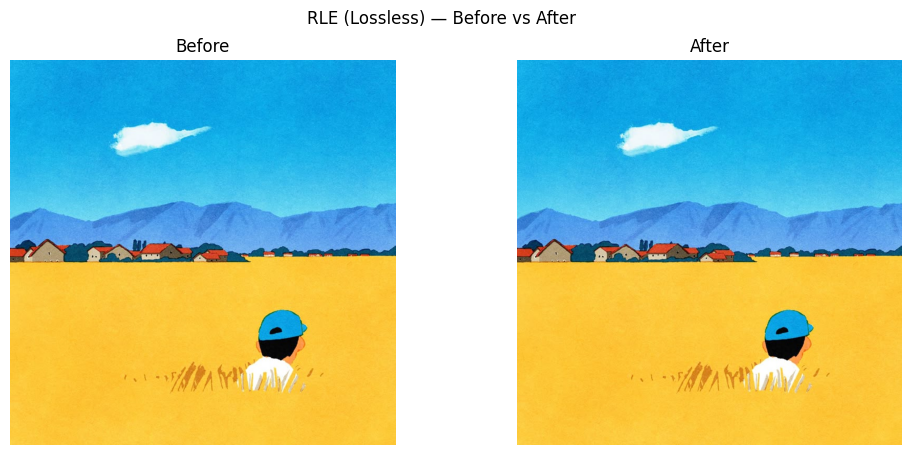

In [12]:
raw = img_to_bytes(img_np)
rle_c = rle_compress(raw)
rle_d = rle_decompress(rle_c)

img_rle = bytes_to_img(rle_d)

ratio, saving = compression_report(len(raw), len(rle_c))
print("RLE")
print("Original bytes:", len(raw))
print("Compressed bytes:", len(rle_c))
print("Compression ratio:", round(ratio, 3), "x")
print("Space saving:", round(saving, 2), "%")
print("PSNR:", psnr(img_np, img_rle))

show_before_after(img_np, img_rle, title="RLE (Lossless) — Before vs After")


In [13]:
def lz_compress_zlib(data: bytes, level: int = 6) -> bytes:
    return zlib.compress(data, level=level)

def lz_decompress_zlib(comp: bytes) -> bytes:
    return zlib.decompress(comp)


LZ via zlib/DEFLATE (Lossless)
Original bytes: 1625100
Compressed bytes: 691138
Compression ratio: 2.351 x
Space saving: 57.47 %
PSNR: inf


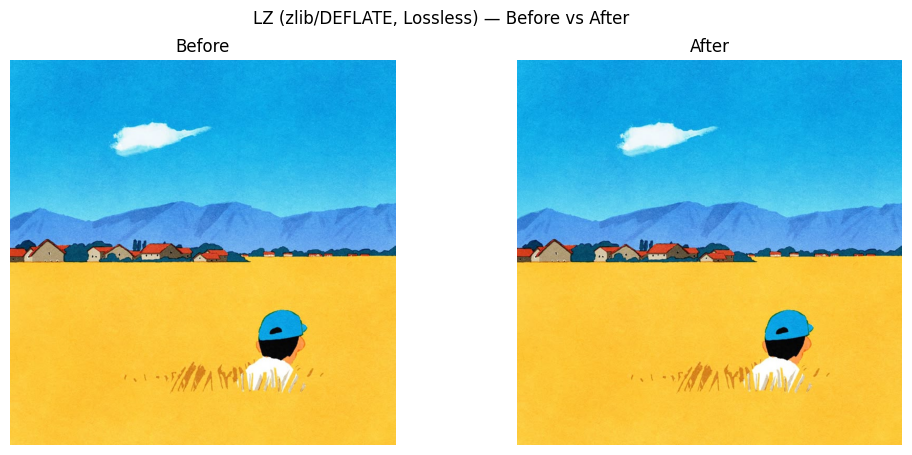

In [14]:
lz_c = lz_compress_zlib(raw, level=6)
lz_d = lz_decompress_zlib(lz_c)

img_lz = bytes_to_img(lz_d)

ratio, saving = compression_report(len(raw), len(lz_c))
print("LZ via zlib/DEFLATE (Lossless)")
print("Original bytes:", len(raw))
print("Compressed bytes:", len(lz_c))
print("Compression ratio:", round(ratio, 3), "x")
print("Space saving:", round(saving, 2), "%")
print("PSNR:", psnr(img_np, img_lz))

show_before_after(img_np, img_lz, title="LZ (zlib/DEFLATE, Lossless) — Before vs After")


In [15]:
class HuffNode:
    def __init__(self, freq, sym=None, left=None, right=None):
        self.freq = freq
        self.sym = sym
        self.left = left
        self.right = right
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freqs: dict):
    heap = [HuffNode(f, sym=s) for s, f in freqs.items()]
    heapq.heapify(heap)
    if len(heap) == 1:
        # edge case: hanya 1 simbol
        only = heap[0]
        return HuffNode(only.freq, left=only, right=None)
    while len(heap) > 1:
        a = heapq.heappop(heap)
        b = heapq.heappop(heap)
        heapq.heappush(heap, HuffNode(a.freq + b.freq, left=a, right=b))
    return heap[0]

def build_codes(node, prefix="", codes=None):
    if codes is None:
        codes = {}
    if node is None:
        return codes
    if node.sym is not None:
        codes[node.sym] = prefix if prefix else "0"
        return codes
    build_codes(node.left, prefix + "0", codes)
    build_codes(node.right, prefix + "1", codes)
    return codes

def pack_bits(bitstring: str) -> bytes:
    pad = (8 - (len(bitstring) % 8)) % 8
    bitstring_padded = bitstring + ("0" * pad)
    out = bytearray()
    for i in range(0, len(bitstring_padded), 8):
        out.append(int(bitstring_padded[i:i+8], 2))
    return bytes([pad]) + bytes(out)  # simpan pad di byte pertama

def unpack_bits(packed: bytes) -> str:
    pad = packed[0]
    data = packed[1:]
    bits = "".join(f"{b:08b}" for b in data)
    if pad:
        bits = bits[:-pad]
    return bits

def huffman_compress(data: bytes) -> bytes:
    freqs = Counter(data)
    tree = build_huffman_tree(freqs)
    codes = build_codes(tree)

    # encode jadi bitstring
    bits = "".join(codes[b] for b in data)
    packed = pack_bits(bits)

    # serialize freqs (codebook) agar decode bisa
    # format: [num_symbols(2 bytes)] + (sym(1 byte), freq(4 bytes)) * n + packed_bits
    items = list(freqs.items())
    header = bytearray()
    header += len(items).to_bytes(2, "little")
    for sym, f in items:
        header.append(sym)
        header += int(f).to_bytes(4, "little")
    return bytes(header) + packed

def huffman_decompress(comp: bytes) -> bytes:
    # read header freqs
    n = int.from_bytes(comp[:2], "little")
    idx = 2
    freqs = {}
    for _ in range(n):
        sym = comp[idx]
        f = int.from_bytes(comp[idx+1:idx+5], "little")
        freqs[sym] = f
        idx += 5

    packed = comp[idx:]
    tree = build_huffman_tree(freqs)

    # decode bitstream
    bits = unpack_bits(packed)

    out = bytearray()
    node = tree
    total = sum(freqs.values())

    # special case tree with one symbol
    if tree.sym is None and tree.right is None and tree.left is not None and tree.left.sym is not None:
        return bytes([tree.left.sym]) * total

    for bit in bits:
        node = node.left if bit == "0" else node.right
        if node is None:
            raise ValueError("Decoding error: reached None node")
        if node.sym is not None:
            out.append(node.sym)
            node = tree
            if len(out) == total:
                break
    return bytes(out)


Huffman (Lossless)
Original bytes: 1625100
Compressed bytes: 1465677
Compression ratio: 1.109 x
Space saving: 9.81 %
PSNR: inf


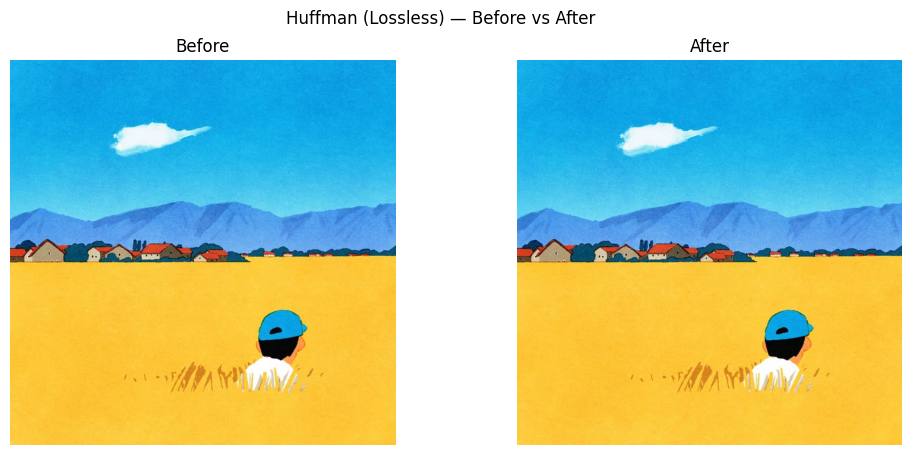

In [16]:
huf_c = huffman_compress(raw)
huf_d = huffman_decompress(huf_c)

img_huf = bytes_to_img(huf_d)

ratio, saving = compression_report(len(raw), len(huf_c))
print("Huffman (Lossless)")
print("Original bytes:", len(raw))
print("Compressed bytes:", len(huf_c))
print("Compression ratio:", round(ratio, 3), "x")
print("Space saving:", round(saving, 2), "%")
print("PSNR:", psnr(img_np, img_huf))

show_before_after(img_np, img_huf, title="Huffman (Lossless) — Before vs After")


In [17]:
def dct_matrix(N=8):
    C = np.zeros((N, N), dtype=np.float32)
    for k in range(N):
        for n in range(N):
            alpha = math.sqrt(1/N) if k == 0 else math.sqrt(2/N)
            C[k, n] = alpha * math.cos((math.pi * (2*n + 1) * k) / (2*N))
    return C

C8 = dct_matrix(8)
Ct8 = C8.T

def dct2(block):
    return C8 @ block @ Ct8

def idct2(coeff):
    return Ct8 @ coeff @ C8

# quantization table ala JPEG luminance (standar)
Q_LUMA = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
], dtype=np.float32)

def dct_compress_reconstruct(img_np, quality=50):
    """
    quality: 1..100 (semakin besar, semakin bagus, kompresi lebih kecil secara konsep)
    Di sini kita rekontruksi dari koefisien kuantisasi untuk tampilan.
    """
    assert 1 <= quality <= 100

    # skala Q seperti JPEG
    if quality < 50:
        scale = 5000 / quality
    else:
        scale = 200 - 2*quality
    Q = np.floor((Q_LUMA * scale + 50) / 100)
    Q[Q == 0] = 1

    # convert ke YCbCr agar mirip JPEG (lebih “real”)
    img = Image.fromarray(img_np, "RGB").convert("YCbCr")
    ycbcr = np.array(img).astype(np.float32)

    h, w, c = ycbcr.shape
    # padding kelipatan 8
    pad_h = (8 - h % 8) % 8
    pad_w = (8 - w % 8) % 8
    padded = np.pad(ycbcr, ((0,pad_h),(0,pad_w),(0,0)), mode="edge")

    recon = np.zeros_like(padded)

    for ch in range(3):
        channel = padded[:,:,ch] - 128.0  # shift
        for i in range(0, padded.shape[0], 8):
            for j in range(0, padded.shape[1], 8):
                block = channel[i:i+8, j:j+8]
                coeff = dct2(block)
                qcoeff = np.round(coeff / Q)  # quantize (lossy)
                deq = qcoeff * Q              # dequantize
                iblock = idct2(deq)
                recon[i:i+8, j:j+8, ch] = iblock

        recon[:,:,ch] += 128.0

    recon = np.clip(recon, 0, 255).astype(np.uint8)
    recon = recon[:h, :w, :]
    recon_rgb = Image.fromarray(recon, "YCbCr").convert("RGB")
    recon_rgb_np = np.array(recon_rgb)

    # estimasi ukuran "kompresi" sederhana:
    # kita anggap yang disimpan adalah qcoeff (int16) untuk semua blok dan channel (belum entropy coding)
    # ini bukan ukuran JPEG asli, tapi cukup untuk membandingkan efek quality.
    num_vals = ((h + pad_h) * (w + pad_w) * 3)
    raw_bytes = h*w*3
    approx_stored = num_vals * 2  # int16
    return recon_rgb_np, raw_bytes, approx_stored, Q


/tmp/ipython-input-2969068301.py:46: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img_np, "RGB").convert("YCbCr")
/tmp/ipython-input-2969068301.py:72: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  recon_rgb = Image.fromarray(recon, "YCbCr").convert("RGB")


DCT (JPEG-like, Lossy)
Quality: 35
Raw pixel bytes (H*W*3): 1625088
Approx stored bytes (quantized coeff int16): 3250176
Approx compression ratio: 0.5 x
Approx space saving: -100.0 %
PSNR: 34.97043616350557
MSE : 20.70316505432129


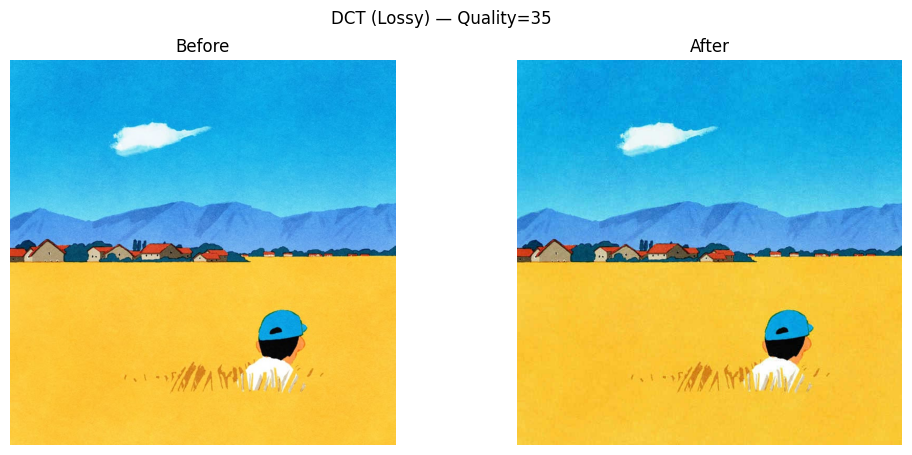

In [18]:
quality = 35  # coba 10, 35, 50, 80

img_dct, raw_pix_bytes, approx_bytes, Q_used = dct_compress_reconstruct(img_np, quality=quality)

ratio, saving = compression_report(raw_pix_bytes, approx_bytes)
print("DCT (JPEG-like, Lossy)")
print("Quality:", quality)
print("Raw pixel bytes (H*W*3):", raw_pix_bytes)
print("Approx stored bytes (quantized coeff int16):", approx_bytes)
print("Approx compression ratio:", round(ratio, 3), "x")
print("Approx space saving:", round(saving, 2), "%")
print("PSNR:", psnr(img_np, img_dct))
print("MSE :", mse(img_np, img_dct))

show_before_after(img_np, img_dct, title=f"DCT (Lossy) — Quality={quality}")


In [19]:
def summarize(name, orig_len, comp_len, before, after):
    ratio, saving = compression_report(orig_len, comp_len)
    return {
        "Algorithm": name,
        "Original(Bytes)": orig_len,
        "Compressed(Bytes)": comp_len,
        "Ratio(x)": round(ratio, 3),
        "Saving(%)": round(saving, 2),
        "PSNR": psnr(before, after)
    }

raw = img_to_bytes(img_np)

# Lossless
rle_c = rle_compress(raw); rle_img = bytes_to_img(rle_decompress(rle_c))
lz_c  = lz_compress_zlib(raw); lz_img  = bytes_to_img(lz_decompress_zlib(lz_c))
huf_c = huffman_compress(raw); huf_img = bytes_to_img(huffman_decompress(huf_c))

# Lossy (pakai estimasi bytes)
quality = 35
dct_img, raw_pix_bytes, approx_bytes, _ = dct_compress_reconstruct(img_np, quality=quality)

rows = []
rows.append(summarize("RLE (lossless)", len(raw), len(rle_c), img_np, rle_img))
rows.append(summarize("LZ zlib/DEFLATE (lossless)", len(raw), len(lz_c), img_np, lz_img))
rows.append(summarize("Huffman (lossless)", len(raw), len(huf_c), img_np, huf_img))

# DCT pakai basis raw pixel bytes (tanpa header), agar gampang dipahami
ratio, saving = compression_report(raw_pix_bytes, approx_bytes)
rows.append({
    "Algorithm": f"DCT JPEG-like (lossy) q={quality}",
    "Original(Bytes)": raw_pix_bytes,
    "Compressed(Bytes)": approx_bytes,
    "Ratio(x)": round(ratio, 3),
    "Saving(%)": round(saving, 2),
    "PSNR": psnr(img_np, dct_img)
})

import pandas as pd
df = pd.DataFrame(rows)
df


/tmp/ipython-input-2969068301.py:46: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img_np, "RGB").convert("YCbCr")
/tmp/ipython-input-2969068301.py:72: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  recon_rgb = Image.fromarray(recon, "YCbCr").convert("RGB")


,Algorithm,Original(Bytes),Compressed(Bytes),Ratio(x),Saving(%),PSNR
0,RLE (lossless),1625100,4859322,0.334,-199.02,inf
1,LZ zlib/DEFLATE (lossless),1625100,691138,2.351,57.47,inf
2,Huffman (lossless),1625100,1465677,1.109,9.81,inf
3,DCT JPEG-like (lossy) q=35,1625088,3250176,0.500,-100.00,34.970436
